<a href="https://colab.research.google.com/github/ishnt/Projects-and-Coursework/blob/main/generating_fake_images_using_dcgans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'celeba-face-recognition-triplets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2937277%2F6531447%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240523%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240523T102732Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7010888c206870e8716dc533346628ff887b4f8fefa28bc87d7e1769d2b93267da90c5be316ccde8126e07219f822b1d904dac1091a42889f5cc899acc879cf0381d3964513d2f83a181ec6e603a53c710fce4e087ee4d82596ac3cd504ae2ae4695280d808b054bcd3380433de6783044e9910fef5eb2eee76d728cba046eebd36345503341c4a921aba4813934260c94019a2621afaea85060020f2822d89c8501b468075f0953766126d85ec3e9edbd5dfedff3d31fa305480a959906fae182ada2ff2248dc290ee5d46f24409c7a7fde3599e3637e2443e6f726040df69fafa91f8e019918eefbf1aeaa82196bfcb462b4496f9dbe7d6365896dc13856ea'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Reshape, Conv2DTranspose
from tensorflow.keras.models import Sequential
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import os
import PIL
import time
from keras.activations import relu,linear, sigmoid
from keras.layers import LeakyReLU
from keras.layers import InputLayer
from IPython import display

2024-03-10 05:30:42.604119: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-10 05:30:42.604217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-10 05:30:42.870489: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [ ]:
root_path = "/kaggle/input/celeba-face-recognition-triplets/CelebA FR Triplets/CelebA FR Triplets/images"
root_path = pathlib.Path(root_path)

In [ ]:
# prepraing data
batch_size = 32

data = keras.utils.image_dataset_from_directory(
    directory=root_path,
    label_mode=None,
    batch_size=batch_size,
    image_size=(64,64))

Found 46371 files.


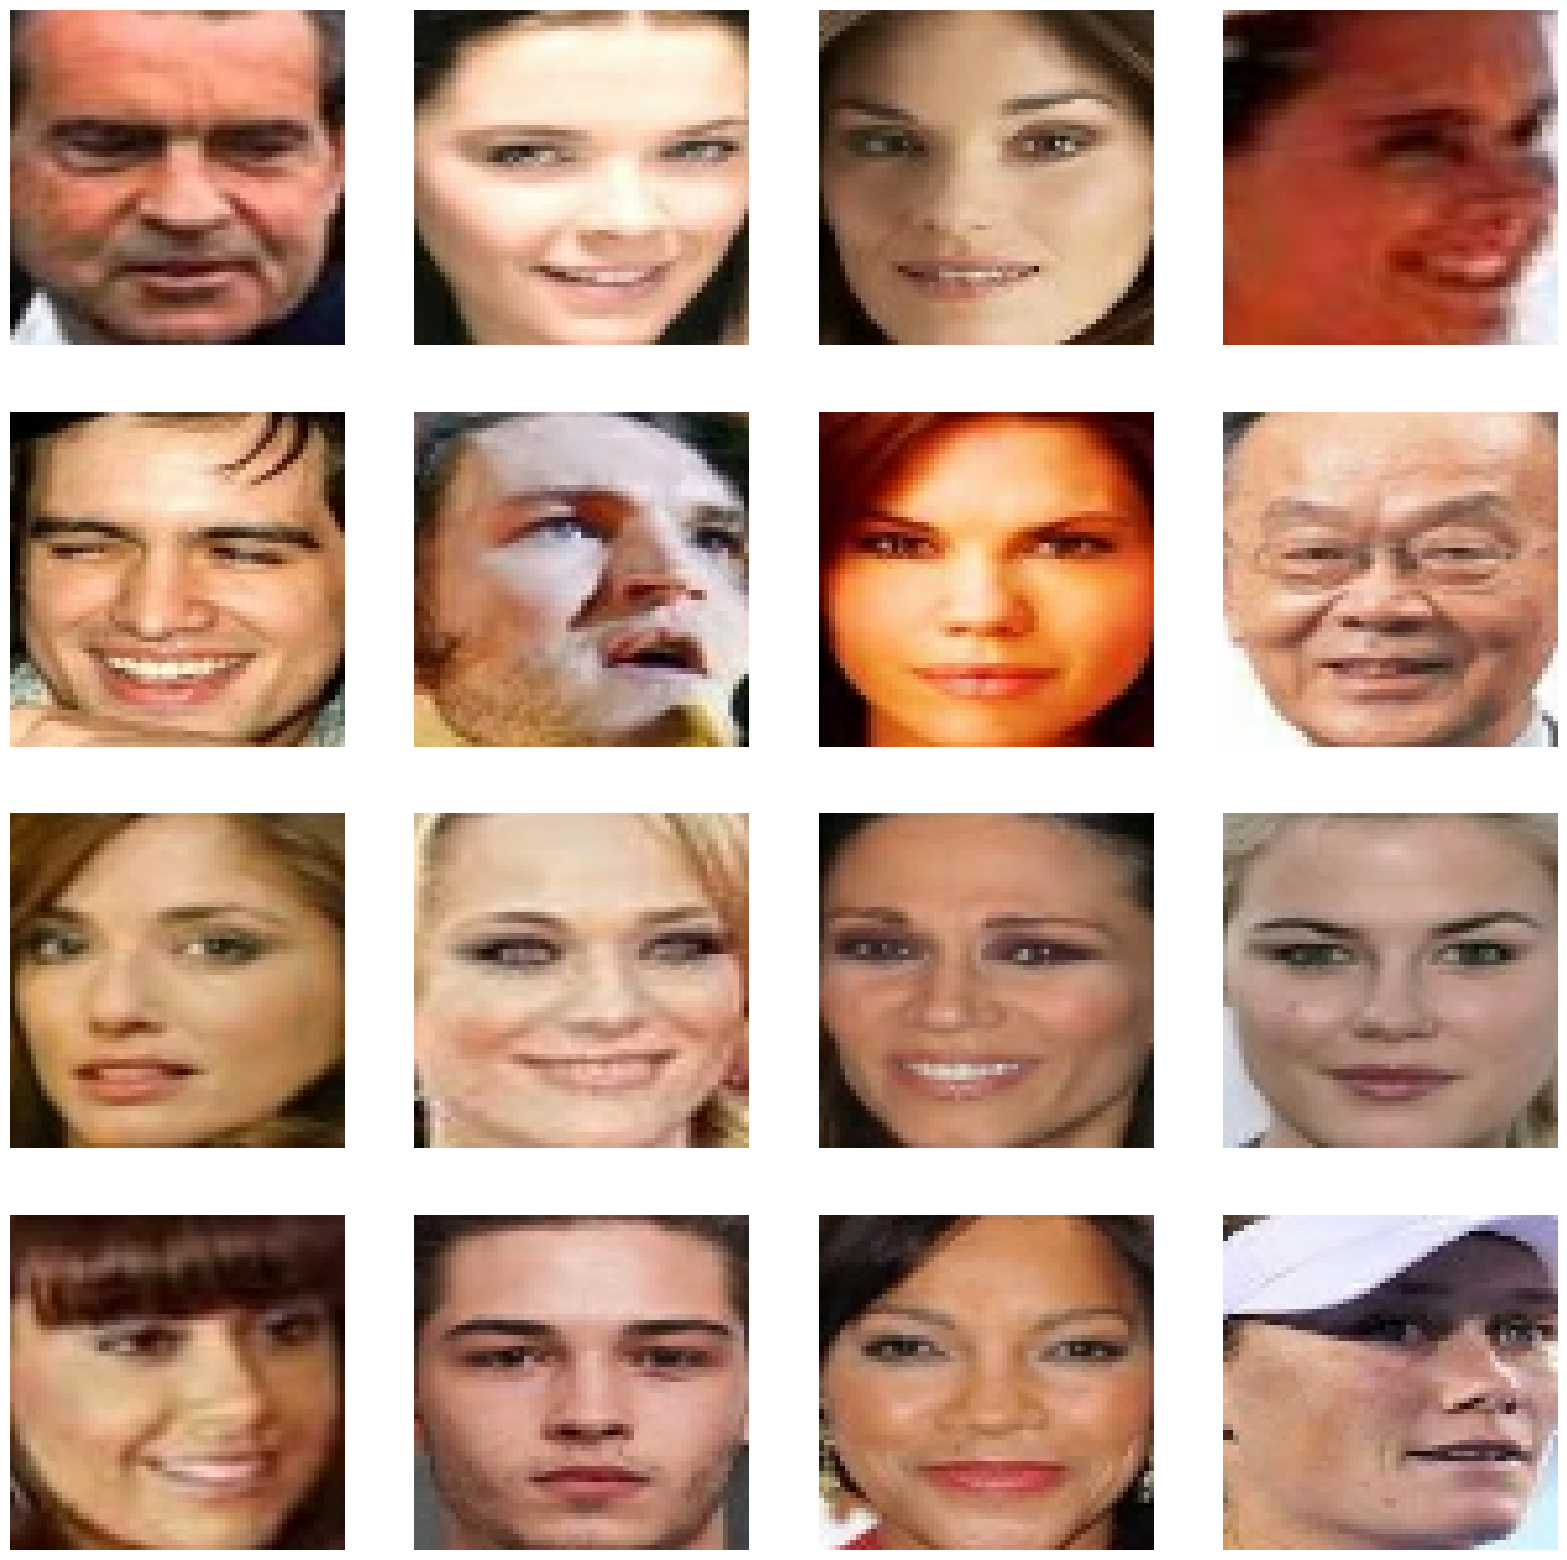

In [ ]:
# let's see some images of the dataset
plt.figure(figsize=(20,20))
for images in data.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
# normalizing the input image to the range [-1, 1]
data = data.map(lambda d : ((d-127.5)/127.5))
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, Dense
from keras.layers import LeakyReLU  # Import LeakyReLU activation function

def Discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(filters=64, kernel_size=3, strides=(2,2), padding="same", activation=LeakyReLU(), input_shape=(64,64,3)))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(filters=128, kernel_size=3, strides=(2,2), padding="same", activation=LeakyReLU()))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Conv2D(filters=256, kernel_size=3, strides=(2,2), padding="same", activation=LeakyReLU()))
    discriminator.add(BatchNormalization())
    discriminator.add(Dropout(0.2))

    discriminator.add(Flatten())
    discriminator.add(Dropout(0.2))
    discriminator.add(Dense(units=1, activation="sigmoid"))

    return discriminator

D_model = Discriminator()
D_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388,993 (1.48 MB)

 Trainable params: 388,097 (1.48 MB)

 Non-trainable params: 896 (3.50 KB)

In [ ]:
# optimizer
D_optm = Adam(1e-4)

In [ ]:
latent_dim = 100

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2DTranspose, BatchNormalization, Reshape, Dense
from keras.activations import relu, tanh  # Import ReLU and tanh activations

# Build the Generator function
def Generator():
    generator = Sequential()
    generator.add(Dense(units=4*4*256, input_shape=[latent_dim], use_bias=False))
    generator.add(Reshape((4, 4, 256)))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=relu))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=relu))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=relu))
    generator.add(BatchNormalization())

    generator.add(Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=(2, 2), padding="same", activation=tanh))

    return generator

# a summary of the Generator
G_model = Generator()
G_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 4096)           │       409,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 64, 64, 3)      │         3,459 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,005,827 (3.84 MB)

 Trainable params: 1,004,547 (3.83 MB)

 Non-trainable params: 1,280 (5.00 KB)

In [ ]:
# optimizer
G_optm = Adam(1e-4)

(-0.5, 63.5, 63.5, -0.5)

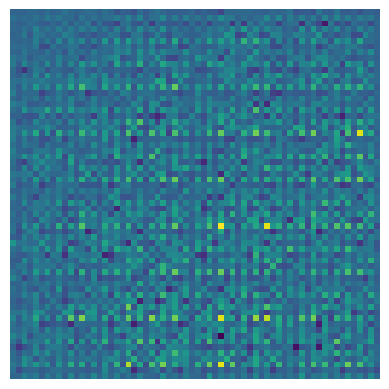

In [ ]:
# creating random noise
random_noise = tf.random.normal([1,latent_dim])
# feeding random noise to Genereator
G_output_on_random_noise = G_model(random_noise, training=False)
# showing the image output of G_model
plt.imshow(G_output_on_random_noise[0, :, :, 0])
plt.axis("off")

In [ ]:
# feeding the output of Generator to Discriminator
D_output_on_random_noise = D_model(G_output_on_random_noise)
print(D_output_on_random_noise)

tf.Tensor([[0.5000026]], shape=(1, 1), dtype=float32)


In [ ]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [ ]:
# loss function
loss_fn = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Defining GAN model
model = GAN(discriminator=D_model, generator=G_model, latent_dim=latent_dim)

In [ ]:
# Compiling GAN Model
model.compile(d_optimizer=D_optm, g_optimizer=G_optm, loss_fn=loss_fn)

In [ ]:
# number of epochs
epochs = 350
# Fitting the GAN model
history = model.fit(data, epochs=epochs)

Epoch 1/350
   5/1450 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - d_loss: 0.6739 - g_loss: 0.6952 

I0000 00:00:1710048828.660825     114 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1450/1450 ━━━━━━━━━━━━━━━━━━━━ 116s 71ms/step - d_loss: 0.0131 - g_loss: 28.5325
Epoch 2/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - d_loss: 0.1975 - g_loss: 3.2101
Epoch 3/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.3141 - g_loss: 2.4635
Epoch 4/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4934 - g_loss: 1.6783
Epoch 5/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4636 - g_loss: 1.6591
Epoch 6/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4544 - g_loss: 1.8207
Epoch 7/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.5265 - g_loss: 1.4795
Epoch 8/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4808 - g_loss: 1.6979
Epoch 9/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4653 - g_loss: 1.6943
Epoch 10/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4434 - g_loss: 1.7845
Epoch 11/350
1450/1450 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - d_loss: 0.4658 - g_loss: 1.6450
Epoch 1

In [ ]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model
generated_images = G_model(noise, training=False)

In [ ]:
# converting the input image to the range [0, 255]
generated_images1 = (generated_images+127.5)*127.5

In [ ]:
# creating a random nosie to feed it to the trained Generator model
noise = tf.random.normal([32, 100])
# Generatine new images using the trained Generator model
generated_images = G_model(noise, training=False)
generated_images1 = (generated_images+127.5)*127.5
plt.figure(figsize=(10,10))
for i in range(20):
    ax = plt.subplot(7, 7, i+1)
    plt.imshow(generated_images1[i].numpy().astype("uint8"))
    plt.axis('off')

plt.show()